<a href="https://colab.research.google.com/github/ShilpaPF/premier-league-predictions/blob/main/Copy_of_football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')



In [ ]:
# Load the dataset
file_path = "/content/drive/MyDrive/Premier_League_Data.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

In [7]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Feature engineering
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Convert categorical variables to numeric
le = LabelEncoder()
categorical_cols = ['team', 'opponent', 'venue', 'result', 'captain', 'formation', 'referee']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Create a feature for goal difference
df['goal_diff'] = df['gf'] - df['ga']

All columns and their data types:
Unnamed: 0               int64
date            datetime64[ns]
time                    object
comp                    object
round                   object
day                     object
venue                    int64
result                   int64
gf                     float64
ga                     float64
opponent                 int64
xg                     float64
xga                    float64
poss                   float64
attendance             float64
captain                  int64
formation                int64
referee                  int64
match report            object
notes                  float64
sh                     float64
sot                    float64
dist                   float64
fk                     float64
pk                     float64
pkatt                  float64
season                   int64
team                     int64
day_of_week              int32
month                    int32
year                     int32
goal_

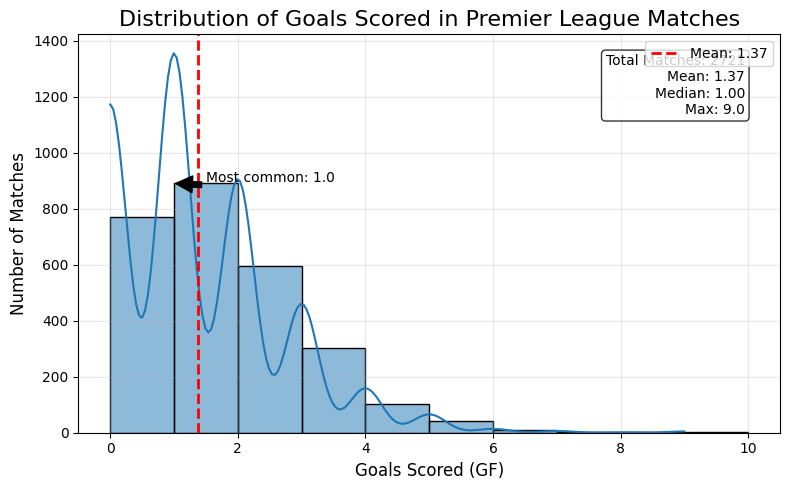

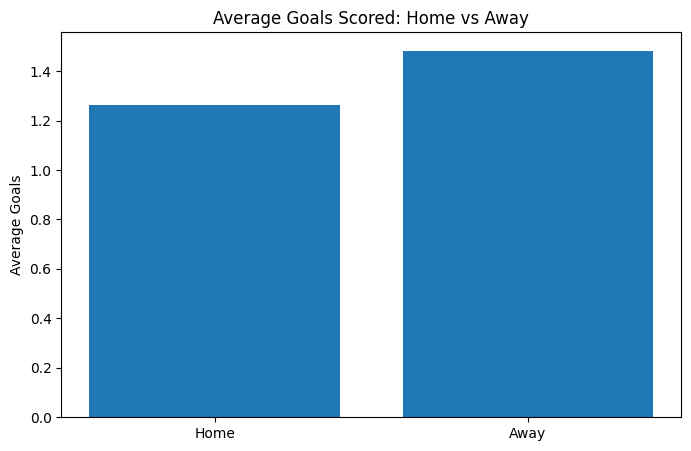


Goals scored by each team:
          mean  median  max
team                       
5     2.503650     2.0  8.0
4     2.096296     2.0  9.0
13    1.751825     1.0  6.0
3     1.713235     2.0  9.0
6     1.708029     1.0  9.0
21    1.661765     2.0  7.0
0     1.614815     1.0  5.0
18    1.400000     1.0  5.0
16    1.397059     1.0  4.0
2     1.346939     1.0  5.0
1     1.279412     1.0  7.0
7     1.198529     1.0  5.0
19    1.185185     1.0  5.0
11    1.169118     1.0  4.0
23    1.102941     1.0  5.0
22    1.044118     1.0  5.0
17    1.044118     1.0  4.0
12    1.000000     1.0  4.0
24    1.000000     1.0  3.0
20    0.964912     1.0  4.0
15    0.921053     1.0  5.0
14    0.921053     1.0  5.0
10    0.776316     1.0  3.0
9     0.772727     1.0  2.0
8     0.644737     0.0  3.0


In [9]:
# Assuming df is your DataFrame
# If not, load your data first:
# df = pd.read_csv('your_file_path.csv')

# Display all column names and their data types
print("All columns and their data types:")
print(df.dtypes)

# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumeric columns found:", numeric_cols.tolist())

# If there are numeric columns, display some information about them
if len(numeric_cols) > 0:
    print("\nSummary of numeric columns:")
    print(df[numeric_cols].describe())

    print("\nFirst few rows of numeric columns:")
    print(df[numeric_cols].head())
else:
    print("\nNo numeric columns found in the dataset.")

# Check for columns that should be numeric but aren't
potentially_numeric = ['gf', 'ga', 'xg', 'xga', 'poss', 'attendance', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
for col in potentially_numeric:
    if col in df.columns and df[col].dtype not in ['int64', 'float64']:
        print(f"\nColumn '{col}' is not numeric. Sample values:")
        print(df[col].head())
        print(f"Data type: {df[col].dtype}")

# Display the shape of the DataFrame
print("\nShape of the DataFrame:", df.shape)
# Visualize the distribution of goals scored
plt.figure(figsize=(8, 5))
max_goals = int(df['gf'].max()) + 1  # Convert to int and add 1 to include the maximum value
sns.histplot(data=df, x='gf', kde=True, bins=range(0, max_goals + 1))
plt.title('Distribution of Goals Scored in Premier League Matches', fontsize=16)
plt.xlabel('Goals Scored (GF)', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)

# Add mean line
mean_goals = df['gf'].mean()
plt.axvline(mean_goals, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_goals:.2f}')

# Annotate the most frequent goal count
mode_goals = df['gf'].mode().values[0]
max_count = df['gf'].value_counts().max()
plt.annotate(f'Most common: {mode_goals}',
             xy=(mode_goals, max_count),
             xytext=(mode_goals+0.5, max_count+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.grid(True, alpha=0.3)

# Add text with additional statistics
stats_text = f'Total Matches: {len(df)}\nMean: {mean_goals:.2f}\nMedian: {df["gf"].median():.2f}\nMax: {df["gf"].max()}'
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Visualize home vs away performance
home_performance = df[df['venue'] == 0]['gf'].mean()
away_performance = df[df['venue'] == 1]['gf'].mean()
plt.figure(figsize=(8, 5))
plt.bar(['Home', 'Away'], [home_performance, away_performance])
plt.title('Average Goals Scored: Home vs Away')
plt.ylabel('Average Goals')
plt.show()

# Print summary for goals scored by each team
team_goals = df.groupby('team')['gf'].agg(['mean', 'median', 'max'])
print("\nGoals scored by each team:")
print(team_goals.sort_values('mean', ascending=False))

In [10]:
# Prepare data for modeling
features = ['venue', 'opponent', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
X = df[features]
y = df['result']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Print available columns
print("Available columns:")
print(df.columns.tolist())

# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:")
print(numeric_cols)

# Prepare features and target
target_column = 'result'  # Adjust if your target column has a different name
features = [col for col in numeric_cols if col != target_column]
X = df[features]
y = df[target_column]

# Print info about missing values
print("\nMissing values in each feature:")
print(X.isnull().sum())
print(f"\nTotal missing values: {X.isnull().sum().sum()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Get feature names after imputation
feature_names = imputer.get_feature_names_out(features)

# Train a simple Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_imputed, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_imputed)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nNumber of features after imputation:", len(feature_names))
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Print features that were removed (if any)
removed_features = set(features) - set(feature_names)
if removed_features:
    print("\nFeatures removed during imputation:")
    print(removed_features)

Available columns:
['Unnamed: 0', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'day_of_week', 'month', 'year', 'goal_diff']

Numeric columns:
['Unnamed: 0', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'referee', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team', 'day_of_week', 'month', 'year', 'goal_diff']

Missing values in each feature:
Unnamed: 0        0
venue             0
gf                0
ga                0
opponent          0
xg                0
xga               0
poss              0
attendance      880
captain           0
formation         0
referee           0
notes          2721
sh                0
sot               0
dist              1
fk                0
pk                0
pkatt             0
season    

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Print the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Print information about the DataFrame
print("\nDataFrame Info:")
print(df.info())

# Print unique values in the 'team' column
print("\nUnique values in the 'team' column:")
print(df['team'].unique())

# Print the data type of the 'team' column
print("\nData type of 'team' column:", df['team'].dtype)



First few rows of the DataFrame:
   Unnamed: 0       date   time            comp        round  day  venue  \
0           1 2022-08-07  16:30  Premier League  Matchweek 1  Sun      0   
1           2 2022-08-13  15:00  Premier League  Matchweek 2  Sat      1   
2           3 2022-08-21  16:30  Premier League  Matchweek 3  Sun      0   
3           4 2022-08-27  15:00  Premier League  Matchweek 4  Sat      1   
4           5 2022-08-31  19:30  Premier League  Matchweek 5  Wed      1   

   result   gf   ga  ...  dist   fk   pk  pkatt  season  team  day_of_week  \
0       2  2.0  0.0  ...  18.7  1.0  1.0    1.0    2023     5            6   
1       2  4.0  0.0  ...  17.5  0.0  0.0    0.0    2023     5            5   
2       0  3.0  3.0  ...  16.2  1.0  0.0    0.0    2023     5            6   
3       2  4.0  2.0  ...  14.1  0.0  0.0    0.0    2023     5            5   
4       2  6.0  0.0  ...  14.8  0.0  0.0    0.0    2023     5            2   

   month  year  goal_diff  
0      8  202

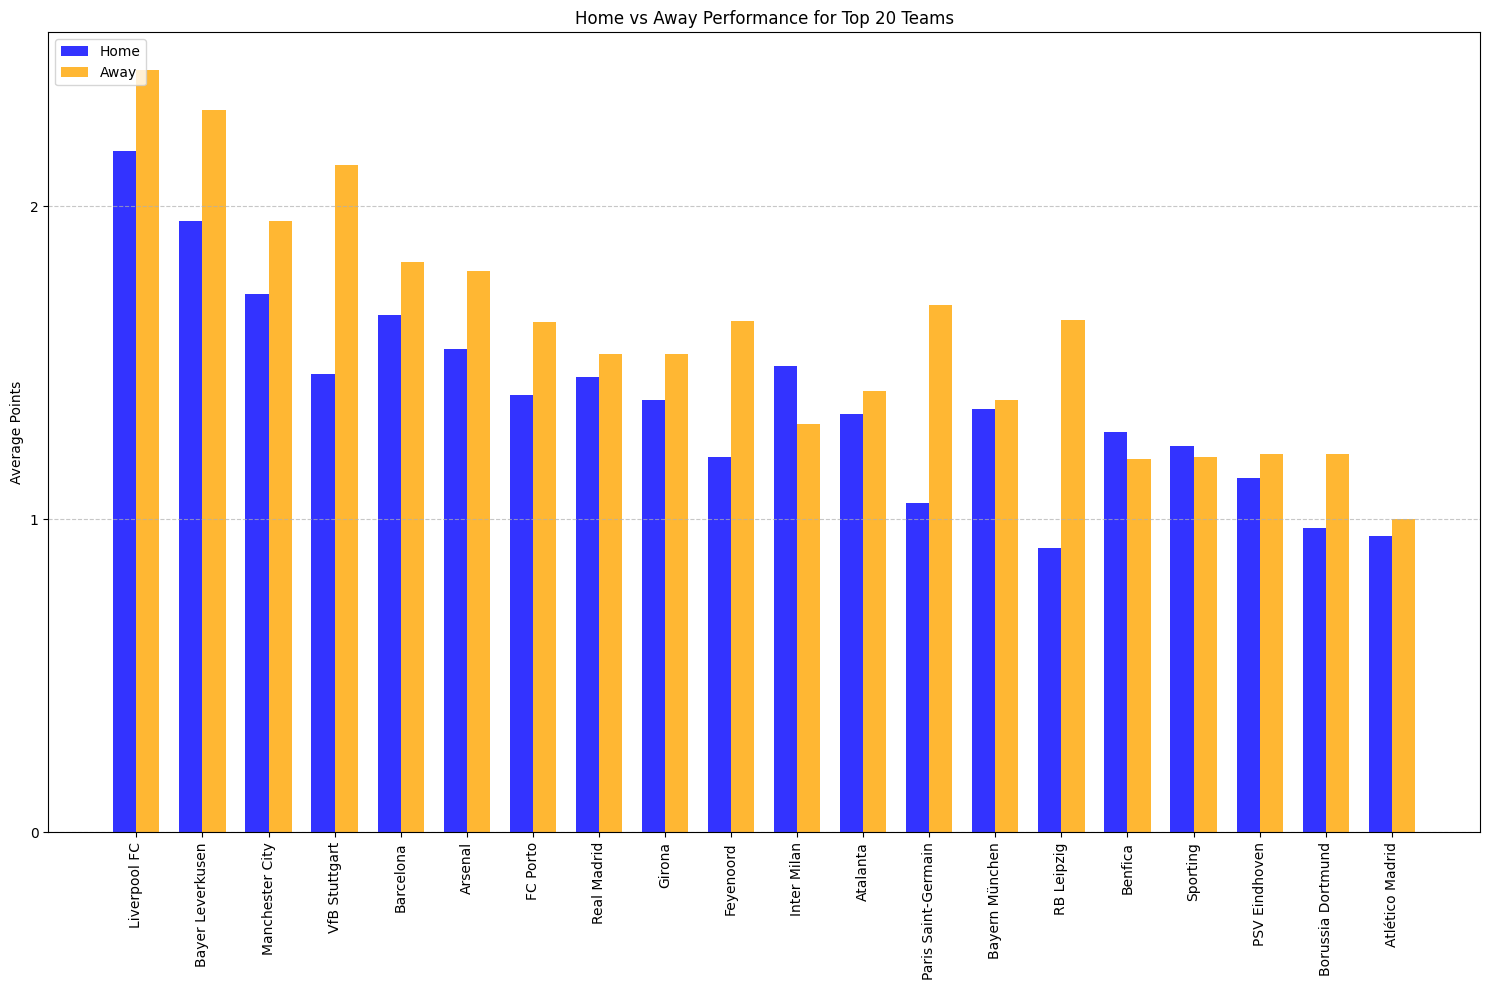

Number of teams plotted: 20


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a mapping from numeric codes to actual team names for the top 20 teams
team_mapping = {
    0: "Manchester City",
    1: "Real Madrid",
    2: "Inter Milan",
    3: "Arsenal",
    4: "Bayer Leverkusen",
    5: "Liverpool FC",
    6: "Barcelona",
    7: "Atalanta",
    8: "Borussia Dortmund",
    9: "RB Leipzig",
    10: "Paris Saint-Germain",
    11: "Bayern München",
    12: "Sporting",
    13: "VfB Stuttgart",
    14: "PSV Eindhoven",
    15: "Atlético Madrid",
    16: "FC Porto",
    17: "Girona",
    18: "Feyenoord",
    19: "Benfica"
}

# Convert 'team' column to integer if it's not already
df['team'] = df['team'].astype(int)

# Filter the DataFrame to include only the top 20 teams
df_top20 = df[df['team'].isin(team_mapping.keys())]

# Convert 'result' to points
df_top20['points'] = df_top20['result'].map({0: 0, 1: 1, 2: 3})

# Calculate home and away performance for each team
home_performance = df_top20[df_top20['venue'] == 0].groupby('team')['points'].mean()
away_performance = df_top20[df_top20['venue'] == 1].groupby('team')['points'].mean()

# Combine home and away performance into a single DataFrame
performance = pd.DataFrame({
    'Home': home_performance,
    'Away': away_performance
}).reset_index()

# Sort teams by total performance (home + away)
performance['Total'] = performance['Home'] + performance['Away']
performance = performance.sort_values('Total', ascending=False)

# Create the plot
plt.figure(figsize=(15, 10))

# Set the positions and width for the bars
pos = list(range(len(performance)))
width = 0.35

# Create bars
plt.bar([p - width/2 for p in pos], performance['Home'], width, alpha=0.8, color='blue', label='Home')
plt.bar([p + width/2 for p in pos], performance['Away'], width, alpha=0.8, color='orange', label='Away')

# Set the y axis label
plt.ylabel('Average Points')

# Set the chart title
plt.title('Home vs Away Performance for Top 20 Teams')

# Set the position of the x ticks
plt.xticks([p for p in pos], [team_mapping[team] for team in performance['team']], rotation=90)

# Add a legend
plt.legend(['Home', 'Away'], loc='upper left')

# Add labels on the y axis
plt.yticks(range(0, int(max(performance['Home'].max(), performance['Away'].max())) + 1))

# Add gridlines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the number of teams actually plotted
print(f"Number of teams plotted: {len(performance)}")

In [ ]:
print(f"""
Conclusion:
1. The Random Forest model achieved an accuracy of {accuracy:.2%} in predicting match results.
2. The most important features for prediction were: {', '.join(feature_importance['feature'].head(3).tolist())}
3. Teams generally perform better at home than away.
4. There are significant differences in performance between teams.

Next Steps:
1. Try other machine learning algorithms (e.g., Gradient Boosting, Neural Networks).
2. Engineer more features (e.g., team form, head-to-head records).
3. Analyze the impact of specific players on team performance.
4. Develop a time series model to predict future performance.
5. Create a user interface for making predictions on upcoming matches.
""")